### Welcome to CLARITY

🧬 CLARITY: Protein-Protein Interaction Clustering Pipeline
This notebook manages the full workflow for the CLARITY analysis tool. It handles environment setup instructions, data import, preprocessing, clustering (Louvain & MCL), enrichment analysis and model validation.

#### 1. Enviroment set-up

First you should set up your enviroment. Please use python3 or above. For ease of use it can be helpful to set up a virtual enviroment and install the required packages found in the "requirements.txt" file.

If you are working in VS code, press cmd+shift+P and find "Python: Create enviroment" and pick the recommended "Quick Create venv" this automatically installs all required packages in a virtual python enviroment.

#### 2. Pipeline helper function

Defining a helper function to execute standalone scripts.

In [17]:
import os
import sys
import subprocess
import platform
from pathlib import Path

def run_script(script_path):
    """
    Executes a Python script using a subprocess to ensure clean execution context.
    """
    script_path = Path(script_path)
    
    if not script_path.exists():
        print(f"FATAL ERROR: Could not find script at '{script_path}'")
        return

    print(f"\n--- Starting {script_path.name}...")

    # Use the current Python executable (sys.executable) to run the script
    command = [sys.executable, str(script_path)]
    
    try:
        # Execute the script, streamlining output to this notebook
        process = subprocess.run(
            command, 
            check=True,
            stdout=sys.stdout,
            stderr=sys.stderr
        )
        print(f"--- {script_path.name} finished successfully.")
        
    except subprocess.CalledProcessError as e:
        print(f"\n--- ERROR: {script_path.name} failed with return code {e.returncode}.")

#### 3. Importing data

Importing data raw protein interaction data files into "_raw/", "cleaned_data.csv", representing a pre-cleaned dataset put into "data/" and the two pre-clustered pickle files "louvain_clust_julle.pkl" and "mcl_data.pkl" into "data/output/" directories.

In [18]:
# Define path to data import
data_import_script = "06_data_import.py"

# Run import
run_script(data_import_script)


--- Starting 06_data_import.py...
--- 06_data_import.py finished successfully.


#### 4. Data Preprocessing

Only run if you want to tweak preprocessing since the preprocessed file is already loaded into the "data/" directory as "cleaned_data.csv"

A data preprocessing script, that removes nodes with only 1 edge and???

In [19]:
# Run preprocessing - this is only necessary if the "data/cleaned_data.csv is not already imported from data import script
#run_script("features/07_preprocessing.py")

### 5. Clustering Algorithms

Run the graph clustering algorithms below if you have the compute power available or want to tweak parameters; otherwise, just use the pre-clustered .pkl files found in the data/output directory. You can uncomment the specific algorithms you wish to run for this session.

##### A. Louvain Clustering
A hierarchical community detection method based on modularity optimization. This algorithm functions as a greedy heuristic that iteratively groups nodes to maximize the density of edges within communities relative to a random null model. In the context of protein-protein interaction (PPI), view Louvain clusters as broad "functional neighborhoods"—like mapping the distinct districts of a city (e.g., the "Metabolism District"). While it excels at identifying large-scale biological processes and global topology due to its hierarchical nature, it can suffer from a "resolution limit" where distinct, small protein complexes are merged into single super-modules if they share even a few connections.

##### B. Markov Clustering (MCL)
A flow-based algorithm that simulates random walks to detect clusters, relying on the intuition that a random walker is more likely to bounce around inside a dense cluster than to leave it. It operates by alternating Expansion (simulating flow spread) and Inflation (pruning weak connections). Biologically, view these clusters as tight-knit "families" or "households"—identifying specific molecular machines (like the Ribosome) rather than broad districts. MCL is often considered the gold standard for defining protein complexes because it handles the noise inherent in interaction data well, though it is sensitive to the inflation parameter: set too high, it fragments valid pathways; set too low, and it lumps distinct complexes together.


In [20]:
# If you already have a TARGET_PROTEIN then set it globally here
TARGET_PROTEIN = "SNCAIP"

#### 5.1 Louvain clustering analysis

In [21]:
# Uncomment to run Louvain Clustering
# Only need to run if the "data/output/louvain_clust_julle.pkl" is not already created. Saving computing time.
#run_script("features/01_run_louvain.py")

#### Global overview of the clustering

PICKLE_FILE and OUTPUT_DIR are global variables for this section.

In [22]:
import sys
import pandas as pd

# Ensure python finds your modules
sys.path.append('features/prot_clust_modules')

# Import the new module
from cluster_overview import (
    get_clustering_summary, 
    generate_cluster_stats_table, 
    get_proteins_in_cluster
)

# Configurate desired global variables
PICKLE_FILE = "data/output/louvain_clust_julle.pkl"
OUTPUT_DIR = "data/output/louvain_analysis"

In [23]:
# Get high-level facts about the network
df_summary = get_clustering_summary(PICKLE_FILE)


[OVERVIEW] Generating global network summary...

--- Network Summary ---


Total Clusters,Avg Cluster Size,Median Cluster Size,Largest Cluster,Smallest Cluster,Modularity Score
32,411.340000,376.500000,1140,10,0.757600


In [25]:
# Generate statistics for all individual clusters and save to "all_cluster_metrics.csv"
df_all_clusters = generate_cluster_stats_table(
    PICKLE_FILE, 
    output_filename="all_cluster_metrics.csv", 
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Calculating statistics for all clusters...
   ✅ Stats saved to: data/output/louvain_analysis/all_cluster_metrics.csv

--- Top 20 Largest Clusters ---


,Cluster ID,Size (Nodes),Edges,Density,Avg Clustering
0,4,1140,10282,0.0158,0.4271
1,9,901,5617,0.0139,0.3970
2,21,688,4411,0.0187,0.4624
3,13,678,9266,0.0404,0.5548
4,20,654,4997,0.0234,0.4143
5,22,652,6936,0.0327,0.4954
6,1,609,3502,0.0189,0.4532
7,29,596,3868,0.0218,0.5252
8,24,558,5873,0.0378,0.4708
9,27,539,3701,0.0255,0.4738


For deep dive analysis, pick a cluster in the network and get all proteins in it, full overview will be found in "proteins_in_cluster_{INTERESTING_CLUSTER_ID}.txt".

In [26]:
# Select a cluster ID you are interested in.
INTERESTING_CLUSTER_ID = 11

# Extract list
protein_list = get_proteins_in_cluster(
    PICKLE_FILE, 
    cluster_id=INTERESTING_CLUSTER_ID, 
    output_filename=f"proteins_in_cluster_{INTERESTING_CLUSTER_ID}.txt",
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Fetching proteins for Cluster ID 11...
   ✅ Saved list to: data/output/louvain_analysis/proteins_in_cluster_11.txt

--- Proteins in Cluster 11 (Showing top 50 of 172) ---
ACHE, ADGRA2, AKAP8L, AMER1, ANKRD42, ANKRD6, ANTXR1, ANTXR2, APC, APC2, APCDD1, ARHGEF19, ARHGEF4, AXIN2, BAMBI, BCHE, CACYBP, CCDC88C, CELSR1, CELSR2, CELSR3, CER1, CHRFAM7A, CHRNA1, CHRNA10, CHRNA2, CHRNA3, CHRNA4, CHRNA5, CHRNA6, CHRNA7, CHRNA9, CHRNB1, CHRNB2, CHRNB3, CHRNB4, CHRND, CHRNE, CHRNG, CKAP4, COLQ, CSNK1A1, CSNK1A1L, CSNK2A3, CTHRC1, CTNNBIP1, CXXC4, DAAM1, DAAM2, DACT1
... and 122 more.


Since a Louvain clustering is not garunteed to find the global maximum of the modularity score, here it's possible to run the clustering with many different seeds to check for consistent clustering results.

Only run if of interest, and if compute power allows it, since it will loop multiple times thorugh the Louvain clustering.


--- Starting 03_reproducibility.py...
--- 03_reproducibility.py finished successfully.
reproducibility_plot.png


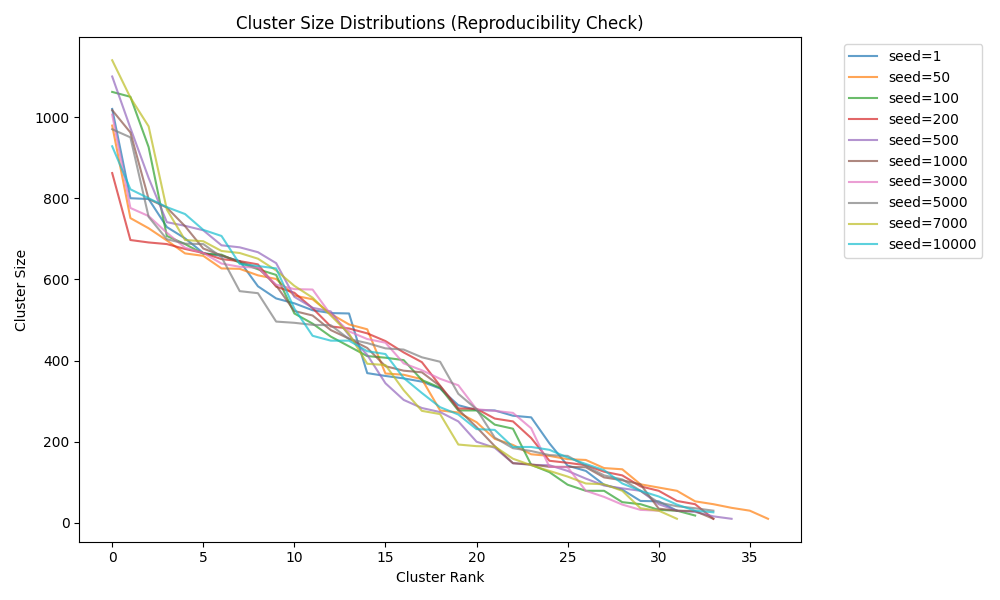

In [27]:

# Uncomment to run analyze clusterers
run_script("features/03_reproducibility.py")

# View results
from IPython.display import Image, display
import os

# Define the path where the script saved the image
image_path = f"{OUTPUT_DIR}/images/reproducibility_plot.png"

# Check if file exists to avoid errors
if os.path.exists(image_path):
    print("reproducibility_plot.png")
    display(Image(filename=image_path))
else:
    print(f"Image not found at {image_path}. Did the script run successfully?")



#### Bottleneck analysis for TARGET_PROTEIN

A topological analysis focused on Betweenness Centrality, identifying nodes that lie on the shortest paths between other pairs of nodes. While clustering focuses on grouping, bottleneck analysis focuses on connecting. Biologically, view these proteins as the "bridges" or "diplomats" of the network. These proteins may not have the highest number of total interactions (degree), but they are critical for "cross-talk"—passing signals between distinct biological modules (e.g., a kinase linking the Cell Cycle cluster to the Apoptosis cluster). Bottlenecks are often evolutionarily conserved and highly essential; removing them tends to be more lethal than removing a central hub, as their absence fragments the network and prevents subsystems from communicating.


--- 🔍 Analyzing Target: AGTRAP ---
[INFO] Found in Cluster #1237 (Size: 2 nodes)
[INFO] Calculating network metrics (Degree, Betweenness, Clustering)...
   > Metrics computed in 0.00s
[INFO] Generating static PNG...
[INFO] Generating interactive HTML...
[SUCCESS] Analysis finished for AGTRAP.

✅ Results for Cluster 1237:


,Protein,Total_Score,BC,Degree,Clustering
0,PITPNC1,3,0.0,1,0
1,AGTRAP,6,0.0,1,0



--- Static Visualization ---


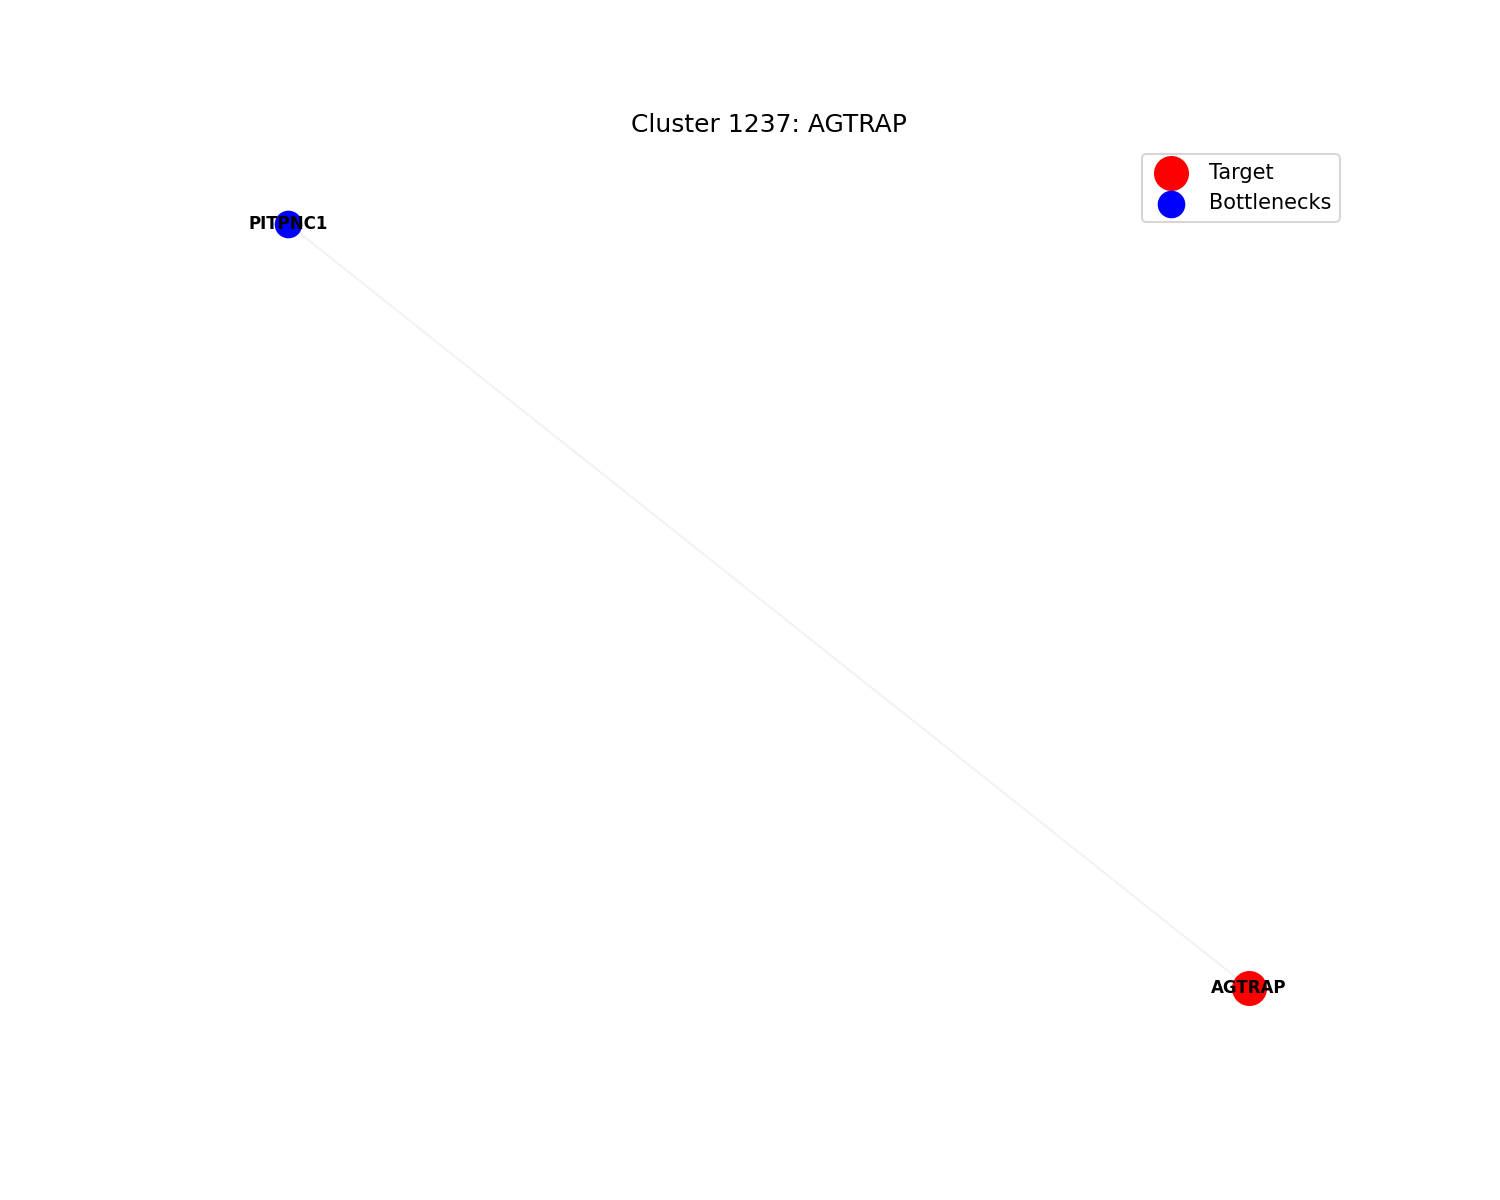

In [ ]:
import sys
# Ensure Python can find your module folder
sys.path.append('./features/prot_clust_modules')

# Import the specific function
from bottleneck_analysis import btl_anal

# Import display tools
from IPython.display import display, IFrame, Image

# --- USER INPUT ---
# Define a global Target Protein to analyze
TARGET_PROTEIN = TARGET_PROTEIN #change manually if needed 

target_protein = TARGET_PROTEIN
pickle_file = PICKLE_FILE
output_dir = OUTPUT_DIR
# ------------------

# Call the function
result = btl_anal(target_protein, pickle_file, output_dir)
# Check results
if result["error"]:
    print(f"{result['error']}")
else:
    print(f"\n Results for Cluster {result['cluster_id']}:")
    
    # 1. Show Top 10 Dataframe
    display(result["dataframe"].head(10))
    
    # 2. Show Static Image
    print("\n--- Static Visualization ---")
    display(Image(filename=result["png_path"]))
    
    # 3. Show Interactive HTML
    #if result["html_path"]:
        #print("\n--- Interactive Visualization (Scroll/Zoom) ---")
        #display(IFrame(src=result["html_path"], width='100%', height='800px'))

#### Enrichment analysis (g:Profiler)

A statistical method used to translate abstract lists of proteins (derived from the clusters) into interpretable biological labels. We utilize g:Profiler to query the KEGG (Kyoto Encyclopedia of Genes and Genomes) and REAC (Reactome) databases (with posibillity to also use the GO database, however it's not recommended due to many duplicate results). Biologically, this serves as the "Directory" or "Signposting" phase. If the previous steps identified a "neighborhood," this step reads the signs to tell you exactly what that neighborhood does (e.g., "This cluster is the Oxidative Phosphorylation department"). By calculating the statistical probability (p-value) that your protein list overlaps with known pathways more than random chance would allow, this validates that your topological clusters correspond to real, functional biological mechanisms.

In [28]:
import sys
import os
from IPython.display import display, HTML

# 1. Add your modules folder to the path so Python can find it
# (Only needs to be done once per notebook session)
if 'features/prot_clust_modules' not in sys.path:
    sys.path.append('./features/prot_clust_modules')

# Force reload to get latest code
import importlib
if 'enrichment_analysis_2' in sys.modules:
    importlib.reload(sys.modules['enrichment_analysis_2'])

#enrichment analysis
# 2. Import the function
from enrichment_analysis_2 import run_enrichment_analysis

# --- USER CONFIGURATION ---
target_protein = TARGET_PROTEIN             # The protein you are investigating
pickle_file = PICKLE_FILE # Or "louvain_data.pkl" depending on which method you want to test
output_dir = OUTPUT_DIR             # Where to save the CSV results
# --------------------------

print(f"Starting Enrichment Analysis for target: {TARGET_PROTEIN}...")

# 3. Run the analysis
# This function will:
#   - Load the graph data
#   - Find the cluster containing SNCAIP
#   - Run ORA (Over-Representation Analysis) against Hallmark gene sets
#   - Save results to CSV
#   - Display top pathways automatically
results_df = run_enrichment_analysis(target_protein, pickle_file, output_dir,clust_algo_used="Louvain")

Starting Enrichment Analysis for target: SNCAIP...

---  Enrichment Analysis (g:Profiler): SNCAIP ---
[INFO] Target found in Cluster #11
[INFO] Analyzing 172 genes against GO:BP and Reactome...
[INFO] Background size: 13163 genes
[INFO] Initializing g:Profiler...
[INFO] Querying g:Profiler API...
   Full results saved to: data/output/louvain_analysis/enrichment_cluster_11_Louvain.csv

--- Top Enriched Pathways (FDR < 0.05) ---


,Source,Term,Overlap,Adjusted P-value,Genes
0,REAC,Signaling by WNT,69/244,7.15e-74,"['CSNK1A1', 'SFRP1', 'RSPO2', 'WNT5B', 'WNT11', 'LGR6', 'SCRIB', 'RNF43', 'HECW1', 'WNT16', 'DAAM1', 'WNT3A', 'WNT9B', 'FZD1', 'WNT1', 'WNT9A', 'APC', 'WNT4', 'WLS', 'LGR4', 'PORCN', 'FZD4', 'FRAT1', 'WNT8A', 'ROR1', 'FZD8', 'FRAT2', 'WNT6', 'DVL1', 'LGR5', 'DKK2', 'LRP5', 'FZD5', 'FZD6', 'AMER1', 'FZD7', 'RSPO1', 'WNT2B', 'KREMEN2', 'ROR2', 'DACT1', 'WNT10A', 'WNT7A', 'FZD3', 'DVL3', 'WNT10B', 'VANGL2', 'FZD2', 'WNT3', 'WNT2', 'CCDC88C', 'SOST', 'WIF1', 'WNT7B', 'SFRP2', 'KREMEN1', 'AXIN2', 'ZNRF3', 'RSPO3', 'DKK4', 'ZRANB1', 'RSPO4', 'DVL2', 'CTNNBIP1', 'DKK1', 'LRP6', 'PRICKLE1', 'RYK', 'WNT8B']"
1,REAC,TCF dependent signaling in response to WNT,47/165,5.73e-49,"['CSNK1A1', 'SFRP1', 'RSPO2', 'LGR6', 'RNF43', 'HECW1', 'WNT3A', 'FZD1', 'WNT1', 'WNT9A', 'APC', 'WNT4', 'LGR4', 'FZD4', 'FRAT1', 'WNT8A', 'FZD8', 'FRAT2', 'DVL1', 'LGR5', 'DKK2', 'LRP5', 'FZD5', 'FZD6', 'AMER1', 'RSPO1', 'KREMEN2', 'DACT1', 'DVL3', 'FZD2', 'WNT3', 'CCDC88C', 'SOST', 'WIF1', 'SFRP2', 'KREMEN1', 'AXIN2', 'ZNRF3', 'RSPO3', 'DKK4', 'RSPO4', 'DVL2', 'CTNNBIP1', 'DKK1', 'LRP6', 'RYK', 'WNT8B']"
2,REAC,WNT ligand biogenesis and trafficking,20/25,2.80e-32,"['WNT5B', 'WNT11', 'WNT16', 'WNT3A', 'WNT9B', 'WNT1', 'WNT9A', 'WNT4', 'WLS', 'PORCN', 'WNT8A', 'WNT6', 'WNT2B', 'WNT10A', 'WNT7A', 'WNT10B', 'WNT3', 'WNT2', 'WNT7B', 'WNT8B']"
3,REAC,Class B/2 (Secretin family receptors),27/80,8.90e-30,"['WNT11', 'WNT16', 'WNT3A', 'WNT9B', 'FZD1', 'WNT1', 'WNT9A', 'WNT4', 'FZD4', 'WNT8A', 'FZD8', 'WNT6', 'FZD5', 'FZD6', 'FZD7', 'WNT2B', 'WNT10A', 'WNT7A', 'FZD9', 'FZD3', 'WNT10B', 'FZD10', 'FZD2', 'WNT3', 'WNT2', 'WNT7B', 'WNT8B']"
4,REAC,Regulation of FZD by ubiquitination,16/17,2.92e-28,"['RSPO2', 'LGR6', 'RNF43', 'WNT3A', 'LGR4', 'FZD4', 'FZD8', 'LGR5', 'LRP5', 'FZD5', 'FZD6', 'RSPO1', 'ZNRF3', 'RSPO3', 'RSPO4', 'LRP6']"
5,REAC,Acetylcholine binding and downstream events,14/14,7.54e-26,"['CHRNE', 'CHRNA7', 'CHRNG', 'CHRNB4', 'CHRNA4', 'CHRNB2', 'CHRNA2', 'CHRND', 'CHRNA9', 'CHRNA5', 'CHRNA6', 'CHRNB3', 'CHRNA1', 'CHRNA3']"
6,REAC,Postsynaptic nicotinic acetylcholine receptors,14/14,7.54e-26,"['CHRNE', 'CHRNA7', 'CHRNG', 'CHRNB4', 'CHRNA4', 'CHRNB2', 'CHRNA2', 'CHRND', 'CHRNA9', 'CHRNA5', 'CHRNA6', 'CHRNB3', 'CHRNA1', 'CHRNA3']"
7,REAC,Negative regulation of TCF-dependent signaling by WNT ligand antagonists,14/14,7.54e-26,"['SFRP1', 'WNT3A', 'WNT9A', 'WNT4', 'DKK2', 'LRP5', 'KREMEN2', 'SOST', 'WIF1', 'SFRP2', 'KREMEN1', 'DKK4', 'DKK1', 'LRP6']"
8,REAC,Disassembly of the destruction complex and recruitment of AXIN to the membrane,17/25,1.14e-25,"['CSNK1A1', 'WNT3A', 'FZD1', 'WNT1', 'APC', 'FRAT1', 'WNT8A', 'FRAT2', 'DVL1', 'LRP5', 'FZD5', 'AMER1', 'DVL3', 'FZD2', 'DVL2', 'LRP6', 'WNT8B']"
9,REAC,PCP/CE pathway,22/67,3.69e-24,"['WNT5B', 'WNT11', 'SCRIB', 'DAAM1', 'FZD1', 'WNT1', 'WNT4', 'FZD4', 'ROR1', 'FZD8', 'DVL1', 'FZD5', 'FZD6', 'FZD7', 'ROR2', 'FZD3', 'DVL3', 'VANGL2', 'FZD2', 'DVL2', 'PRICKLE1', 'RYK']"


### 6.2 Markov Clustering (MCL)

Note:

Instead of running the MCL on your computer, just grap the mcl_data.pkl and put it in the "data/output" directory, file here: https://drive.google.com/drive/folders/1lYrvIDpD_2BXirGHBIgoYeByp1yPRsZ4?usp=sharing. Only applies if you experineced a break in the 06_data_import script.

In [ ]:
# Uncomment to run High Performance MCL
# Only need to run if "data/output/mcl_data.pkl" does not exist. To save computing power.

#run_script("features/05_markov_clust_highperformance_object_out.py")


--- 🚀 Starting 05_markov_clust_highperformance_object_out.py...
--- ✅ 05_markov_clust_highperformance_object_out.py finished successfully.


In [4]:
import sys
import pandas as pd

# Ensure python finds your modules
sys.path.append('features/prot_clust_modules')

# Import the new module
from cluster_overview import (
    get_clustering_summary, 
    generate_cluster_stats_table, 
    get_proteins_in_cluster
)

# Configate desired global variables
PICKLE_FILE = "data/output/mcl_data.pkl"
OUTPUT_DIR = "data/output/mcl_analysis"


Global Overview of the MCL clustering

In [5]:
# Get high-level facts about the network
df_summary = get_clustering_summary(PICKLE_FILE)


[OVERVIEW] Generating global network summary...

--- Network Summary ---


Total Clusters,Avg Cluster Size,Median Cluster Size,Largest Cluster,Smallest Cluster,Modularity Score
561,23.460000,10.000000,362,1,0.673100


In [6]:
# Generate table for all clusters
df_all_clusters = generate_cluster_stats_table(
    PICKLE_FILE, 
    output_filename="all_cluster_metrics.csv", 
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Calculating statistics for all clusters...
   ✅ Stats saved to: data/output/mcl_analysis/all_cluster_metrics.csv

--- Top 20 Largest Clusters ---


,Cluster ID,Size (Nodes),Edges,Density,Avg Clustering
0,0,362,1956,0.0299,0.4037
1,1,269,5711,0.1584,0.7164
2,2,206,3906,0.1850,0.6310
3,3,201,3118,0.1551,0.5096
4,4,186,2276,0.1323,0.4410
5,5,177,1526,0.0980,0.5119
6,6,156,3366,0.2784,0.5948
7,7,151,901,0.0796,0.5096
8,8,139,3715,0.3873,0.7095
9,9,136,1035,0.1127,0.5907


In [ ]:
# Select a cluster ID you are interested in.
INTERESTING_CLUSTER_ID = 11

# Extract list
protein_list = get_proteins_in_cluster(
    PICKLE_FILE, 
    cluster_id=INTERESTING_CLUSTER_ID, 
    output_filename=f"proteins_in_cluster_{INTERESTING_CLUSTER_ID}.txt",
    output_dir=OUTPUT_DIR
)


[OVERVIEW] Fetching proteins for Cluster ID 23...
   ✅ Saved list to: data/output/mcl_analysis/proteins_in_cluster_23.txt

--- Proteins in Cluster 23 (Showing top 50 of 93) ---
AAGAB, AAK1, AFTPH, AGFG1, AGFG2, AMPH, AP1B1, AP1G1, AP1G2, AP1M1, AP1M2, AP1S1, AP1S2, AP1S3, AP2A1, AP2A2, AP2B1, AP2M1, AP2S1, AP3B1, AP3B2, AP3D1, AP3M1, AP3M2, AP3S1, AP3S2, AP4B1, AP4E1, AP4M1, AP4S1, AP5B1, AP5M1, AP5S1, AP5Z1, ARPIN-AP3S2, BAIAP2L2, BIN1, BIN2, BIN3, BMP2K, CCDC32, CCDC62, CLHC1, CLINT1, CLTA, CLTB, CLTCL1, DAB2, DNAJC6, DNM1
... and 43 more.


#### Bottleneck analysis for TARGET_PROTEIN

A topological analysis focused on Betweenness Centrality, identifying nodes that lie on the shortest paths between other pairs of nodes. While clustering focuses on grouping, bottleneck analysis focuses on connecting. Biologically, view these proteins as the "bridges" or "diplomats" of the network. These proteins may not have the highest number of total interactions (degree), but they are critical for "cross-talk"—passing signals between distinct biological modules (e.g., a kinase linking the Cell Cycle cluster to the Apoptosis cluster). Bottlenecks are often evolutionarily conserved and highly essential; removing them tends to be more lethal than removing a central hub, as their absence fragments the network and prevents subsystems from communicating.


--- 🔍 Analyzing Target: SNCAIP ---
[INFO] Found in Cluster #867 (Size: 2 nodes)
[INFO] Calculating network metrics (Degree, Betweenness, Clustering)...
   > Metrics computed in 0.01s
[INFO] Generating static PNG...
[INFO] Generating interactive HTML...
[SUCCESS] Analysis finished for SNCAIP.

✅ Results for Cluster 867:


,Protein,Total_Score,BC,Degree,Clustering
0,SNCAIP,3,0.0,1,0
1,NUB1,6,0.0,1,0



--- Static Visualization ---


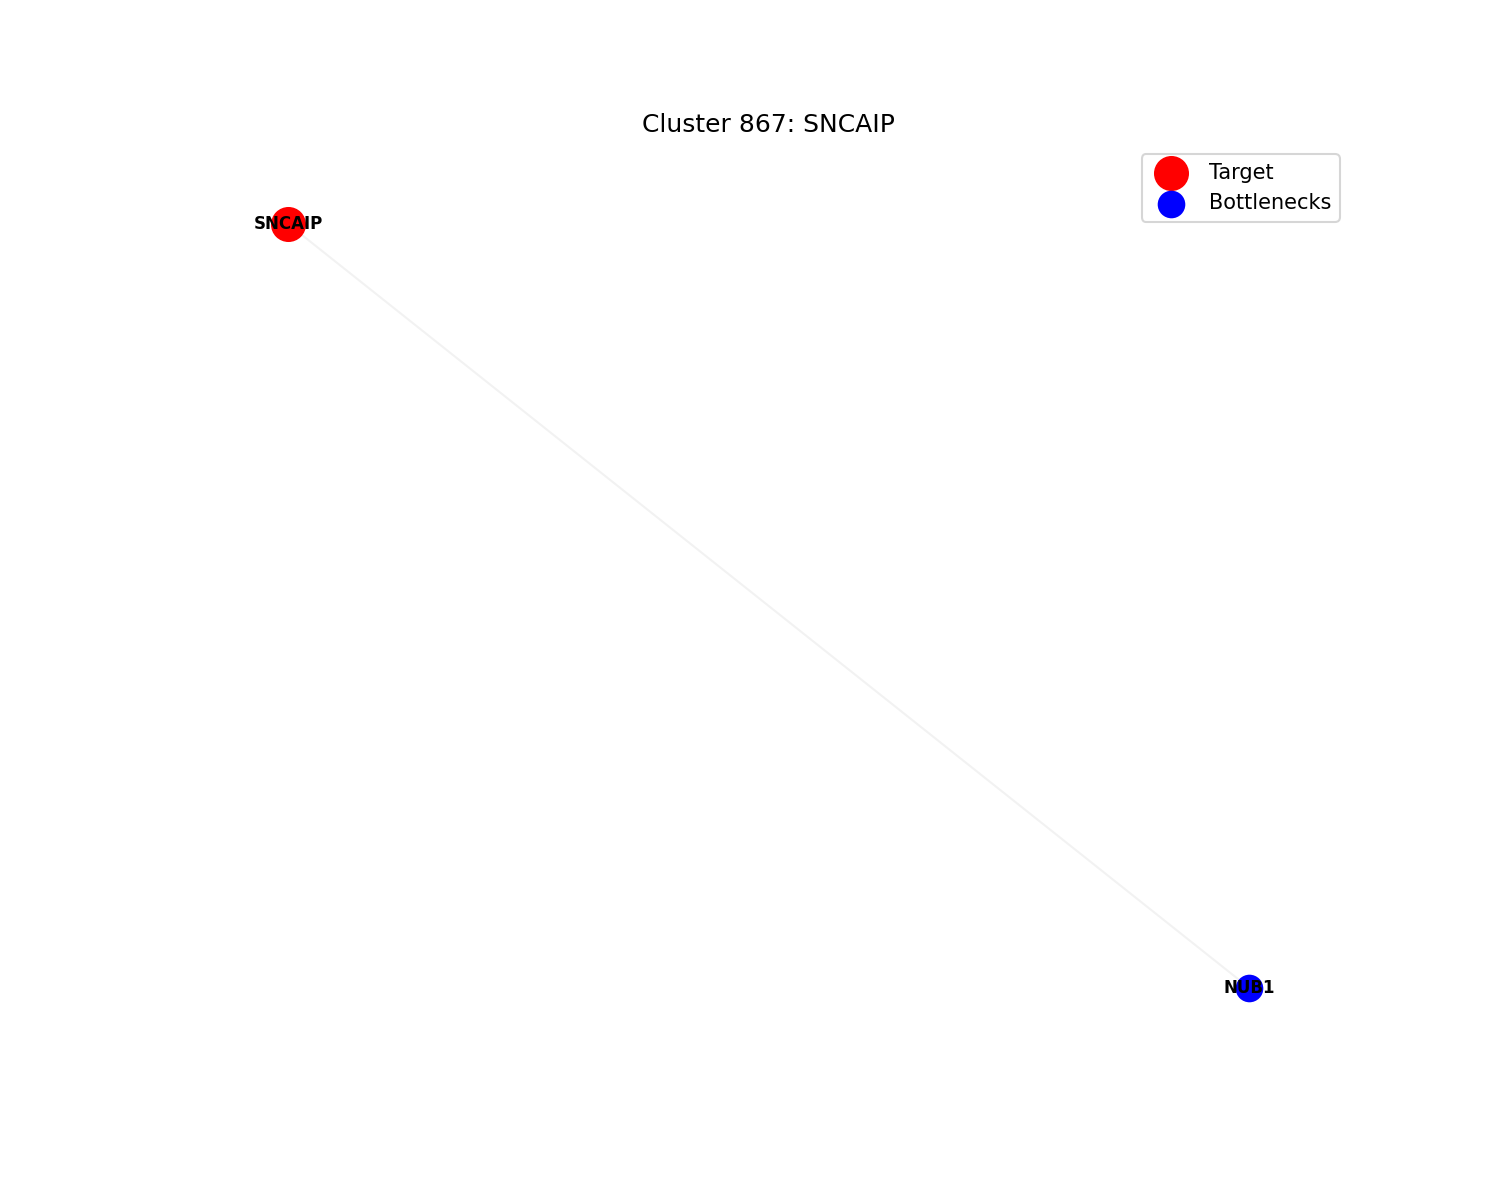

In [ ]:
import sys
# Ensure Python can find your module folder
sys.path.append('./features/prot_clust_modules')

# Import the specific function
from bottleneck_analysis import btl_anal

# Import display tools
from IPython.display import display, IFrame, Image

# --- USER INPUT ---
# Input specific protein to analyze or use the global TARGET_PROTEIN defined in Louvain analysis.
target_protein = TARGET_PROTEIN
pickle_file = PICKLE_FILE
output_dir = OUTPUT_DIR
# ------------------

# Call the function
result = btl_anal(target_protein, pickle_file, output_dir)

# Check results
if result["error"]:
    print(f"{result['error']}")
else:
    print(f"\nResults for Cluster {result['cluster_id']}:")
    
    # 1. Show Top 10 Dataframe
    display(result["dataframe"].head(10))
    
    # 2. Show Static Image
    print("\n--- Static Visualization ---")
    display(Image(filename=result["png_path"]))
    
    # 3. Show Interactive HTML
    #if result["html_path"]:
        #print("\n--- Interactive Visualization (Scroll/Zoom) ---")
        #display(IFrame(src=result["html_path"], width='100%', height='800px'))

#### Enrichment analysis (g:Profiler)

A statistical method used to translate abstract lists of proteins (derived from the clusters) into interpretable biological labels. We utilize g:Profiler to query the KEGG (Kyoto Encyclopedia of Genes and Genomes) and REAC (Reactome) databases (with posibillity to also use the GO database, however it's not recommended due to many duplicate results). Biologically, this serves as the "Directory" or "Signposting" phase. If the previous steps identified a "neighborhood," this step reads the signs to tell you exactly what that neighborhood does (e.g., "This cluster is the Oxidative Phosphorylation department"). By calculating the statistical probability (p-value) that your protein list overlaps with known pathways more than random chance would allow, this validates that your topological clusters correspond to real, functional biological mechanisms.

In [ ]:
import sys
import os
from IPython.display import display, HTML

# 1. Add your modules folder to the path so Python can find it
# (Only needs to be done once per notebook session)
if 'features/prot_clust_modules' not in sys.path:
    sys.path.append('./features/prot_clust_modules')

# Force reload to get latest code
import importlib
if 'enrichment_analysis_2' in sys.modules:
    importlib.reload(sys.modules['enrichment_analysis_2'])

#enrichment analysis
# 2. Import the function
from enrichment_analysis_2 import run_enrichment_analysis

# --- USER CONFIGURATION ---
target_protein = TARGET_PROTEIN             # The protein you are investigating
pickle_file = PICKLE_FILE # Or "louvain_data.pkl" depending on which method you want to test
output_dir = OUTPUT_DIR             # Where to save the CSV results
# --------------------------

print(f"Starting Enrichment Analysis for target: {TARGET_PROTEIN}...")

# 3. Run the analysis
# This function will:
#   - Load the graph data
#   - Find the cluster containing SNCAIP
#   - Run ORA (Over-Representation Analysis) against Hallmark gene sets
#   - Save results to CSV
#   - Display top pathways automatically
results_df = run_enrichment_analysis(target_protein, pickle_file, output_dir,clust_algo_used="MCL")

🔬 Starting Enrichment Analysis for target: SNCAIP...

--- 🧬 Enrichment Analysis (g:Profiler): SNCAIP ---
[INFO] Target found in Cluster #277
[INFO] Analyzing 10 genes against GO:BP and Reactome...
[INFO] Background size: 13163 genes
[INFO] Initializing g:Profiler...
[INFO] Querying g:Profiler API...
   ✅ Full results saved to: data/output/mcl_analysis/enrichment_cluster_277_MCL.csv

--- Top Enriched Pathways (FDR < 0.05) ---


,Source,Term,Overlap,Adjusted P-value,Genes
0,REAC,Peptide ligand-binding receptors,4/171,1.12e-04,"['PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
1,REAC,Class A/1 (Rhodopsin-like receptors),4/286,2.87e-04,"['PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
2,REAC,G alpha (i) signalling events,4/262,2.87e-04,"['PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
3,REAC,GPCR ligand binding,4/401,8.08e-04,"['PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
4,REAC,GPCR downstream signalling,4/519,1.75e-03,"['PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
5,REAC,Signaling by GPCR,4/581,2.25e-03,"['PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
6,REAC,NR1H2 & NR1H3 regulate gene expression to limit cholesterol uptake,1/4,1.30e-02,['MYLIP']
7,REAC,Signal Transduction,5/2065,2.77e-02,"['MYLIP', 'PSAP', 'GPR37L1', 'BDKRB1', 'GPR37']"
8,REAC,VLDLR internalisation and degradation,1/11,2.77e-02,['MYLIP']


### 7. Model validation through Enrichment analysis

To evaluate the biological relevance of our topological clusters, we calculate a "Functional Coherence" metric based on enrichment data from KEGG and Reactome. For each generated cluster, we determine the percentage of member proteins that map to at least one statistically significant pathway. This validation relies on the heuristic that higher pathway engagement implies better clustering, as it suggests the algorithm successfully recovered a verified biological module rather than a random aggregation of noise. While this metric provides a quantitative proxy for accuracy, it is inherently limited by annotation bias, potentially penalizing valid clusters composed of uncharacterized proteins or novel complexes not yet described in the databases.

In [ ]:
import sys
# Ensure Python can find your module folder
sys.path.append('./features/prot_clust_modules')

# Import the specific function
from method_validation_enrichment import run_validation_analysis

import os

# --- 2. Define your parameters ---
# Change these paths to match where your pickle files actually are
louvain_pickle_path = "data/output/louvain_clust_julle.pkl" 
mcl_pickle_path = "data/output/mcl_data.pkl"
output_directory = "data/output/validation_metrics"

# --- 3. Run Validation for Louvain ---
if os.path.exists(louvain_pickle_path):
    print("Running validation for Louvain...")
    df_louvain_val = run_validation_analysis(
        pickle_path=louvain_pickle_path,
        output_dir=output_directory,
        clust_algo_used="Louvain"
    )
    
    # Display top 5 rows of the result
    if df_louvain_val is not None:
        display(df_louvain_val.head())
else:
    print(f"File not found: {louvain_pickle_path}")


# Takes a long time to run for MCL, so uncomment only if needed

"""
# --- 4. Run Validation for MCL (Optional) ---
if os.path.exists(mcl_pickle_path):
    print("\nRunning validation for MCL...")
    df_mcl_val = run_validation_analysis(
        pickle_path=mcl_pickle_path,
        output_dir=output_directory,
        clust_algo_used="MCL"
    )
    
    if df_mcl_val is not None:
        display(df_mcl_val.head())
"""


Running validation for Louvain...

--- 🧪 Validation Analysis (Curated Pathways): Louvain ---
--- ⚙️  Sources: Reactome (REAC), WikiPathways (WP), KEGG ---
--- ⚙️  Correction: Bonferroni (Strict) | P < 0.05 ---
[INFO] Background universe size: 13163 genes.
[INFO] Starting iteration over clusters...
   ... Processed 10/32 clusters
   ... Processed 20/32 clusters
   ... Processed 30/32 clusters

✅ Results saved: data/output/validation_metrics/validation_curated_Louvain.csv

--- 📊 Global Stats (Louvain) ---
Avg % Proteins in Pathways: 42.16%
Avg # Pathways per Cluster: 43.00


,Cluster_ID,Total_Proteins,Significant_Pathways,Unique_Significant_Proteins,Percentage_Involved
0,0,86,13,41,47.674419
1,1,609,53,336,55.172414
2,2,349,37,153,43.839542
3,3,32,1,15,46.875000
4,4,1140,144,740,64.912281



Running validation for MCL...

--- 🧪 Validation Analysis (Curated Pathways): MCL ---
--- ⚙️  Sources: Reactome (REAC), WikiPathways (WP), KEGG ---
--- ⚙️  Correction: Bonferroni (Strict) | P < 0.05 ---
[INFO] Background universe size: 13163 genes.
[INFO] Starting iteration over clusters...
   ... Processed 10/931 clusters
   ... Processed 20/931 clusters
   ... Processed 30/931 clusters
   ... Processed 40/931 clusters
   ... Processed 50/931 clusters
   ... Processed 60/931 clusters
   ... Processed 70/931 clusters
   ... Processed 80/931 clusters
   ... Processed 90/931 clusters
   ... Processed 100/931 clusters
   ... Processed 110/931 clusters
   ... Processed 120/931 clusters
   ... Processed 130/931 clusters
   ... Processed 140/931 clusters
   ... Processed 150/931 clusters
   ... Processed 160/931 clusters
   ... Processed 170/931 clusters
   ... Processed 180/931 clusters
   ... Processed 190/931 clusters
   ... Processed 200/931 clusters
   ... Processed 210/931 clusters
   

,Cluster_ID,Total_Proteins,Significant_Pathways,Unique_Significant_Proteins,Percentage_Involved
0,0,199,39,109,54.773869
1,1,190,7,50,26.315789
2,2,190,49,162,85.263158
3,3,173,23,109,63.005780
4,4,156,35,107,68.589744


### Special cases and Appendix

#### Girvan-Newman clustering algorithm

Something

In [ ]:
# Uncomment to run Girvan-Newman Clustering
# !!!!!! IMPORTANT !!!!!!
# Girvan-Newman is computationally intensive and takes a long time to run on the full graphdataset.

run_script("features/08_run_girvan_full.py")

##### Subset of the dataset to run Girvan-Newman

In [ ]:
# Uncomment to run Girvan-Newman Clustering on the subgraph
# !!!!!! IMPORTANT !!!!!!
# Girvan-Newman is computationally intensive and takes a some time to run, even on the subset.

run_script("features/08_run_girvan_subgraph.py")

In [ ]:
print("\n✨ All pipeline tasks complete! ✨")